# RNN
---

hello world 찍어보기

$$\begin{aligned} 
h_t &= tanh(W_{hh} h_{t-1} + W_{xh} x_t + b_h) \\
y_t &= W_{hy} h_{t} + b_y
\end{aligned}$$

Size:
$$\begin{aligned}
x_t &: V, \\
h_t &: N, \\
y_t &: M, \\
W_{xh} &: V \times N \\
W_{hh} &: N \times N ,\quad where \ t=0 \ init \ as \ 0s\\
W_{hy} &: M \times N \\
b_h &: N, \\
b_y &: M, 
\end{aligned}$$

### Forward

In [1]:
from common.utils_nn import *
from common.layers import *
from common.optimizer import *
from collections import OrderedDict, defaultdict

In [2]:
class Single_layer_RNN(object):
    def __init__(self, input_size, hidden_size, output_size, bptt_truncate):
        self.input_size = input_size # V
        self.hidden_size = hidden_size # N
        self.output_size = output_size # M
        self.bptt_truncate = bptt_truncate
        
        self.params = {}
        self.params_init()
        
        self.layers = None
        self.last_layers = None
        self.T = None
        self.h0 = None
        
    def params_init(self):
        scale_xh = np.sqrt(1.0 / self.input_size)
        scale_hh = np.sqrt(1.0 / self.hidden_size)
        self.params['W_xh'] = np.random.randn(self.input_size, self.hidden_size) * scale_xh
        self.params['W_hh'] = np.random.randn(self.hidden_size, self.hidden_size) * scale_hh
        self.params['W_hy'] = np.random.randn(self.hidden_size, self.output_size) * scale_hh
        self.params['b_h'] = np.zeros((1, self.hidden_size))
        self.params['b_y'] = np.zeros((1, self.output_size))
    
    def _hidden_init(self):
        self.h0 = np.zeros((1, self.hidden_size))
        return self.h0
    
    def _layers_init(self):
        self.layers = defaultdict(OrderedDict)
        for i in np.arange(self.T):
            self.layers['Affine_xh'][i] = Linear(self.params['W_xh'], bias=False)
            self.layers['Affine_hh'][i] = Linear(self.params['W_hh'], self.params['b_h'])
            self.layers['Tanh'][i] = Tanh()
            self.layers['Affine_hy'][i] = Linear(self.params['W_hy'], self.params['b_y'])
    
    def _last_layers_init(self):
        self.last_layers = {}
        for i in np.arange(self.T):
            self.last_layers[i] = SoftmaxWithLoss()
    
    def forward(self, x):
        self.T = len(x)
        if self.layers is None:
            self._layers_init()
        
        hs = {}
        hs[-1] = self._hidden_init()
        os = {}
        
        for i in np.arange(self.T):
            a = self.layers['Affine_hh'][i].forward(hs[i-1]) + \
                self.layers['Affine_xh'][i].forward(x[i:i+1, :])
            hs[i] = self.layers['Tanh'][i].forward(a)
            os[i] = self.layers['Affine_hy'][i].forward(hs[i])
            
        return os, hs

    def predict(self, x):
        os, hs = self.forward(x)
        result = []
        for i in np.arange(self.T):
            max_idx = np.argmax(os[i])
            result.append(max_idx)
        return np.array(result)
            
    def loss(self, x, t):
        total_loss = 0
        os, hs = self.forward(x)
        if self.last_layers is None:
            self._last_layers_init()
        
        for i in range(self.T):
            loss = self.last_layers[i].forward(os[i], t[i].reshape(1, -1))
            total_loss += loss
        
        return total_loss / len(t)

    def backward(self):
        # BPTT
        self._params_summation_init()
        dht = np.zeros_like(self.h0)
        
        for t in np.arange(self.T)[::-1]:
            dout = self.last_layers[t].backward()
            dht_raw = self.layers['Affine_hy'][t].backward(dout)
            dat = self.layers['Tanh'][t].backward(dht_raw) + dht 
            dht = self.layers['Affine_hh'][t].backward(dat)
            dx = self.layers['Affine_xh'][t].backward(dat) # dx
            self._params_summation(t)
#         self._params_summation(key=False)

    def _params_summation_init(self):
        self.params_summ = {}
        self.summ_count = 0
        self.params_summ['W_xh'] = np.zeros_like(self.params['W_xh'])
        self.params_summ['W_hh'] = np.zeros_like(self.params['W_hh'])
        self.params_summ['W_hy'] = np.zeros_like(self.params['W_hy'])
        self.params_summ['b_h'] = np.zeros_like(self.params['b_h'])
        self.params_summ['b_y'] = np.zeros_like(self.params['b_y'])
    
    def _params_summation(self, step=None, key=True):
        if key:
            self.summ_count += 1
            self.params_summ['W_xh'] += self.layers['Affine_xh'][step].dW
            self.params_summ['W_hh'] += self.layers['Affine_hh'][step].dW
            self.params_summ['W_hy'] += self.layers['Affine_hy'][step].dW
            self.params_summ['b_h'] += self.layers['Affine_hh'][step].db
            self.params_summ['b_y'] += self.layers['Affine_hy'][step].db
        else:
            for k, v in self.params_summ.items():
                self.params_summ[k] = v / self.summ_count

    def backward_truncate(self):
        # TBPTT
        self._params_summation_init()
        dht = np.zeros_like(self.h0)
        
        for t in np.arange(self.T)[::-1]:
            dout = self.last_layers[t].backward()
            dht_raw = self.layers['Affine_hy'][t].backward(dout)
            self.params_summ['W_hy'] += self.layers['Affine_hy'][t].dW
            self.params_summ['b_y'] += self.layers['Affine_hy'][t].db
            
            for bptt_step in np.arange(max(0, t-self.bptt_truncate), t+1)[::-1]:
                dat = self.layers['Tanh'][bptt_step].backward(dht_raw) + dht 
                dht = self.layers['Affine_hh'][bptt_step].backward(dat)
                dx = self.layers['Affine_xh'][bptt_step].backward(dat) # dx
                self.params_summ['W_xh'] += self.layers['Affine_xh'][bptt_step].dW
                self.params_summ['W_hh'] += self.layers['Affine_hh'][bptt_step].dW
                self.params_summ['b_h'] += self.layers['Affine_hh'][bptt_step].db

    def gradient_check(self, x, t, delta=0.001, th_error=0.1, num_check=3):
        ks = list(self.params_summ.keys())
        f = lambda w: self.loss(x, t)
        for name in ks:
            s0 = self.params[name].shape
            s1 = self.params_summ[name].shape
            assert s0 == s1, \
                "[Error] dimensions don't match: ({}) params-{} grads-{}".format(name, s0, s1)
            for i in np.arange(num_check):
                num_grads = numerical_gradient(f, self.params[name])
                back_grads = self.params_summ[name]
                rel_error = np.abs(back_grads - num_grads) / (np.abs(back_grads) + np.abs(num_grads))
                mask = rel_error > th_error
            print(name, mask.sum())

In [3]:
class chr_coding(object):
    def __init__(self):
        self._dict = None
        self._one_hot_matrix = None
        self._dict_reversed = None
        
    def fit(self, x):
        if isinstance(x, str):
            x = list(x)
        
        self._one_hot_matrix = np.eye(len(set(x)))
        self._dict = {d: i for i, d in enumerate(list(set(x)))}
        self._dict_reversed = {v: k for k, v in self._dict.items()}
        
    def encode(self, x):
        encoded_data = np.array([self._one_hot_matrix[self._dict[d]] for d in x])
        return encoded_data
    
    def decode(self, x, probs=None):
        if probs is None:
            decoded_data = self._dict_reversed[x]
        else:
            decoded_data = self._dict_reversed[np.argmax(probs)]
        return decoded_data

In [4]:
x = 'hello world! nice to meet you'
data = list(x)

encoder = chr_coding()
encoder.fit(data)
one_hot_data = encoder.encode(data)

In [29]:
np.random.seed(164)
num_epochs = 3000
input_size = one_hot_data.shape[1]
hidden_size = 20
output_size = one_hot_data.shape[1]
seq_len = one_hot_data.shape[0] - 1

In [30]:
train_x = one_hot_data[:-1]
train_y = one_hot_data[1:]

In [31]:
rnn = Single_layer_RNN(input_size, hidden_size, output_size, bptt_truncate=4)
optim = Adam()

In [32]:
# 일반 BPTT 쓰게 되면 Gradient가 끝까지 전파되기 않기 때문에 모델이 불안정하게 됨
total_loss_list = []

for epoch in range(num_epochs):
    test_string = 'h'
    # forward
    total_loss = rnn.loss(train_x, train_y)
    
    # backward
    rnn.backward()
    
    optim.update(rnn.params, rnn.params_summ)
    
    # test
    predicted_idx = rnn.predict(train_x)
    for idx in predicted_idx:
        test_string += encoder.decode(idx)
    if epoch % 100 == 0:
        print('#{}, Loss: {}, test: "{}"'.format(epoch, total_loss, test_string))
    elif epoch == (num_epochs-1):
        print('#{}, Loss: {}, test: "{}"'.format(epoch, total_loss, test_string))

    total_loss_list.append(total_loss)    

#0, Loss: 2.8103684760806806, test: "hidlye odcycudlwdlhmmuudlmcmi"
#100, Loss: 2.0372387021464378, test: "hillt  uillt milllt murll  mu"
#200, Loss: 1.7359780943393324, test: "hillt ourllt ouelt  ourll  ou"
#300, Loss: 1.5231447418029502, test: "hellt ourll! oueett oueet oou"
#400, Loss: 1.443287978781342, test: "hell! ouell  oieelt omell  om"
#500, Loss: 1.4910316840134843, test: "hell! wuell  wmeel ooieet ooi"
#600, Loss: 1.3344370638101795, test: "hell! wuell  wieel ooieel  ou"
#700, Loss: 1.3250769374885745, test: "hell! wmeet ooieed ooieel  ou"
#800, Loss: 1.321421539726438, test: "hell  oiee t oieelt wmell  ou"
#900, Loss: 1.2362434127826059, test: "heldt oiee ! oieelt wmell  wu"
#1000, Loss: 1.144137541885762, test: "heed! oieed! oieelto melt  ou"
#1100, Loss: 1.0466100542802308, test: "heed! nieed! nieetto uelt oou"
#1200, Loss: 1.083557677583643, test: "hee ! oieed! nieelt omret you"
#1300, Loss: 0.9537371317191752, test: "held! nieldo niellt omeet you"
#1400, Loss: 0.9375836

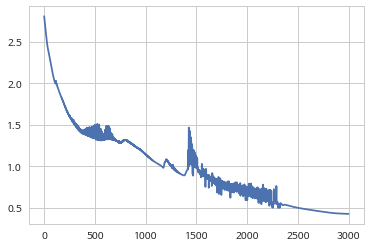

In [33]:
plt.plot(total_loss_list)

In [34]:
rnn = Single_layer_RNN(input_size, hidden_size, output_size, 4)
optim = Adam()

In [35]:
total_loss_list = []

for epoch in range(num_epochs):
    test_string = 'h'
    # forward
    total_loss = rnn.loss(train_x, train_y)
    
    # backward
    rnn.backward_truncate()
    
    optim.update(rnn.params, rnn.params_summ)
    
    # test
    predicted_idx = rnn.predict(train_x)
    for idx in predicted_idx:
        test_string += encoder.decode(idx)
    if epoch % 100 == 0:
        print('#{}, Loss: {}, test: "{}"'.format(epoch, total_loss, test_string))
    elif epoch == (num_epochs-1):
        print('#{}, Loss: {}, test: "{}"'.format(epoch, total_loss, test_string))

    total_loss_list.append(total_loss)

#0, Loss: 2.8113184995019473, test: "ht!wiiuwwun!lu!oc!woroi!m!u!w"
#100, Loss: 2.2747661796984042, test: "ht!wo mwr m!rnmwr tor !!r t!u"
#200, Loss: 1.9467829645777506, test: "hteco wor d!rnier yor iorndou"
#300, Loss: 1.7621592531111197, test: "hlecl wo  do  ieo you io  you"
#400, Loss: 1.588097601078203, test: "hllc  wo  do  ieo yo  io  you"
#500, Loss: 1.4605258779206944, test: "hllc  wo  d!  ieo yo  do  you"
#600, Loss: 1.3494170338079556, test: "hllo  wo  d!  ieo ye  do  you"
#700, Loss: 1.247656903776035, test: "hlle  wo  d!  ico ye  do  you"
#800, Loss: 1.1521574544118593, test: "hlle  wo  d!  ico te ndo  you"
#900, Loss: 1.0619571368566219, test: "hlle  wor d! nico te ndo  you"
#1000, Loss: 0.9773822963427239, test: "hlle  wor d! nico te mdo  you"
#1100, Loss: 0.8989477105581232, test: "hlle  wor d! nico te meo  you"
#1200, Loss: 0.8268751893564925, test: "hlle  wor d! nice to meo  you"
#1300, Loss: 0.7610724087642732, test: "hlll  wor d! nice to meo  you"
#1400, Loss: 0.70122

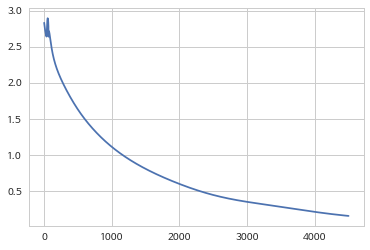

In [17]:
plt.plot(total_loss_list)

## Keras로 해보면?

In [18]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from keras.utils import np_utils

Using TensorFlow backend.
/Users/Soo/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Encoding Class

In [2]:
class chr_coding(object):
    def __init__(self):
        self._dict = None
        self._one_hot_matrix = None
        self._dict_reversed = None
        
    def fit(self, x):
        if isinstance(x, str):
            x = list(x)
        
        self._one_hot_matrix = np.eye(len(set(x)))
        self._dict = {d: i for i, d in enumerate(list(set(x)))}
        self._dict_reversed = {v: k for k, v in self._dict.items()}
        
    def encode(self, x, onehot=True):
        if onehot:
            encoded_data = np.array([self._one_hot_matrix[self._dict[d]] for d in x])
        else:
            encoded_data = np.array([self._dict[d] for d in x], dtype=np.float)
        return encoded_data
    
    def decode(self, x=None, probs=None):
        if probs is None:
            decoded_data = self._dict_reversed[x]
        else:
            decoded_data = self._dict_reversed[np.argmax(probs)]
        return decoded_data

### Loss History Class

In [3]:
class LossHistory(keras.callbacks.Callback):
    def __init__(self):
        self.losses=[]
    
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

### 목표

h $\rightarrow$ e <br>
e $\rightarrow$ l <br>
l $\rightarrow$ l <br>
$\vdots$ <br>
l $\rightarrow$ d

### 데이터 생성 및 One hot Vector로 바꿔주기

In [4]:
x = 'hello world'
data = list(x)

encoder = chr_coding()
encoder.fit(data)
data = encoder.encode(data, onehot=False)

### train_x 와 train_y 지정하기

In [5]:
encoder._dict

{' ': 1, 'd': 7, 'e': 6, 'h': 2, 'l': 4, 'o': 5, 'r': 0, 'w': 3}

In [6]:
train_x = data[:-1].reshape(-1, 1)
train_y = data[1:]

In [7]:
train_y = np_utils.to_categorical(train_y)
train_y

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [8]:
train_x = train_x.reshape(10, 1, 1)

In [9]:
train_x

array([[[ 2.]],

       [[ 6.]],

       [[ 4.]],

       [[ 4.]],

       [[ 5.]],

       [[ 1.]],

       [[ 3.]],

       [[ 5.]],

       [[ 0.]],

       [[ 4.]]])

### 모델 만들기

* input_dim: 벡터의 크기 ($x_t$의 길이)
* input_length: 순서열의 길이 ($t$가 총몇인지)

### model: stateful LSTM

In [18]:
model = Sequential()
model.add(LSTM(14, batch_input_shape=(1, 1, 1), stateful=True))
model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = LossHistory()
history.__init__()

In [19]:
num_epochs = 1000
for epoch in range(num_epochs):
    print('epochs: {}'.format(epoch))
    model.fit(train_x, train_y, epochs=1, batch_size=1, shuffle=False, callbacks=[history])
    model.reset_states()

epochs: 0
Epoch 1/1
10/10 [==============================] - 1s 101ms/step - loss: 2.0667 - acc: 0.0000e+00
epochs: 1
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 2.0428 - acc: 0.2000
epochs: 2
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 2.0273 - acc: 0.3000
epochs: 3
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 2.0134 - acc: 0.3000
epochs: 4
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 2.0005 - acc: 0.4000
epochs: 5
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 1.98

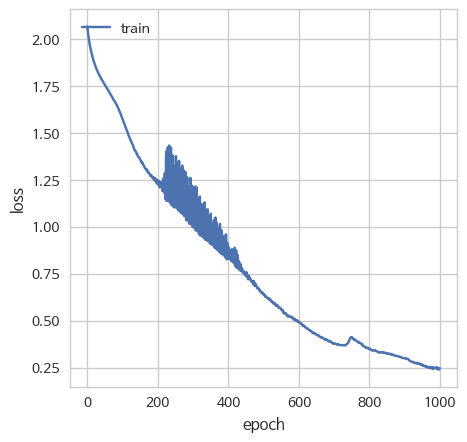

In [20]:
plt.figure(figsize=(5, 5), dpi=100)
plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [25]:
scores = model.evaluate(train_x, train_y, batch_size=1)
print('{}: {}'.format(model.metrics_names[1], scores[1]))

10/10 [==============================] - 0s 1ms/step
acc: 0.0


In [29]:
model.reset_states()

In [30]:
pred_out = model.predict(train_x, batch_size=1)
word = ''
for i in range(len(x)-1):
    probs = pred_out[i]
    letter = encoder.decode(probs=probs)
    word += letter
    print('input : "{}" | predict "{}"| word : "h{}"'.format(x[i], letter, word))


input : "h" | predict "e"| word : "he"
input : "e" | predict "l"| word : "hel"
input : "l" | predict "l"| word : "hell"
input : "l" | predict "o"| word : "hello"
input : "o" | predict " "| word : "hello "
input : " " | predict "w"| word : "hello w"
input : "w" | predict "o"| word : "hello wo"
input : "o" | predict "r"| word : "hello wor"
input : "r" | predict "l"| word : "hello worl"
input : "l" | predict "d"| word : "hello world"
